In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

compat_rename = {'Ultimate Tensile Strength': 'Tensile Strength, Ultimate',
                 'Yield Strength': 'Tensile Strength, Yield',
                 'Elongation': 'Elongation at Break',
                 'names': 'Name'}

In [2]:
nickel_data = pd.read_csv("full_set.csv", index_col=0)
# nickel_data = nickel_data.drop(columns="Name")
nickel_data = nickel_data.rename(columns=compat_rename)
nickel_data.head()

,Name,"Tensile Strength, Yield",Pressure treated,Area under heat treatment curve,Strengthening Precipitate Phase,Powder processed,Al,B,C,Co,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,Allvac718PLUS,989.0,No,392890.0,GammaPrime,No,1.5,0.005,0.020,9.1,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,HastelloyS,NaN,No,0.0,NaN,No,0.3,0.000,0.000,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,Haynes230,NaN,No,0.0,NaN,No,0.3,0.000,0.100,0.0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Waspaloy,NaN,No,19572.0,NaN,No,1.3,0.001,0.035,13.4,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Unnamedalloy10,NaN,No,0.0,NaN,No,5.7,0.000,0.000,15.0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for Yield

In [3]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

yield_data = hf.clean_dataframe(nickel_data, "Tensile Strength, Yield")
yield_data.head()

,"Tensile Strength, Yield",Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,...,O,Zr,Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
0,989.0,392890.0,1.5,0.005,0.020,9.100000,17.40,0.0,9.7,0.0,...,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1074.0,12349.0,0.0,0.000,0.050,0.000000,20.00,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1055.0,0.0,5.0,0.020,0.070,18.530001,12.38,0.0,0.0,0.0,...,0.0,0.060,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12,260.0,4441.0,0.0,0.000,0.150,20.000000,21.00,0.0,30.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,1581.0,24006.0,2.5,0.030,0.025,14.750000,16.00,0.0,0.0,0.0,...,0.0,0.035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:

yield_train_data = yield_data.sample(frac=0.8, random_state=2212)
yield_test_data = yield_data.drop(yield_train_data.index)

yield_data.head()

,"Tensile Strength, Yield",Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,...,O,Zr,Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
0,989.0,392890.0,1.5,0.005,0.020,9.100000,17.40,0.0,9.7,0.0,...,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1074.0,12349.0,0.0,0.000,0.050,0.000000,20.00,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1055.0,0.0,5.0,0.020,0.070,18.530001,12.38,0.0,0.0,0.0,...,0.0,0.060,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12,260.0,4441.0,0.0,0.000,0.150,20.000000,21.00,0.0,30.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,1581.0,24006.0,2.5,0.030,0.025,14.750000,16.00,0.0,0.0,0.0,...,0.0,0.035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [5]:
yield_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"Tensile Strength, Yield",837.0,798.445923,305.243958,40.0,607.000,825.000000,1005.000000,1.654000e+03
Area under heat treatment curve,837.0,33278.945312,137448.109375,0.0,4605.000,13253.000000,24530.000000,1.743038e+06
Al,837.0,2.295579,1.958159,0.0,0.500,1.500000,3.670000,6.600000e+00
B,837.0,0.010083,0.014280,0.0,0.000,0.006000,0.015000,1.600000e-01
C,837.0,0.058011,0.043522,0.0,0.025,0.050000,0.070000,1.800000e-01
Co,837.0,8.290035,7.826919,0.0,0.000,9.500000,14.750000,3.500000e+01
Cr,837.0,15.934528,4.777830,0.0,13.660,17.000000,19.000000,2.950000e+01
Cu,837.0,0.004779,0.097706,0.0,0.000,0.000000,0.000000,2.000000e+00
Fe,837.0,6.533286,11.133636,0.0,0.000,0.000000,14.100000,4.522000e+01
Hf,837.0,0.095404,0.342386,0.0,0.000,0.000000,0.000000,1.800000e+00


In [6]:
yield_train_features = yield_train_data.copy()
yield_test_features = yield_test_data.copy()

yield_train_labels = yield_train_features.pop("Tensile Strength, Yield")
yield_test_labels = yield_test_features.pop("Tensile Strength, Yield")

In [7]:
yield_normalizer = hf.normalize(yield_train_features)

First example: [[1316.      0.3     0.      0.05    0.     20.      0.      0.      0.
     0.      0.      0.      0.      0.      0.     78.      0.      0.
     0.      0.      0.      0.5     0.      0.      0.47    0.      0.13
     0.      0.      0.      0.      0.      0.      0.      1.      0.  ]]

Normalized: [[-0.23 -1.02 -0.71 -0.18 -1.06  0.85 -0.05 -0.59 -0.28 -0.08 -0.1  -0.38
  -1.08 -0.11 -0.72  2.12 -0.3  -0.06  0.   -0.53 -0.42 -0.99 -0.17 -0.49
   2.48 -0.07  2.34 -0.51 -0.22 -0.19 -0.54 -1.33 -0.27 -0.07  5.59 -0.48]]


In [8]:
def builder(hp): return hf.model_builder_variable(hp,
                                                  yield_normalizer,
                                                  test_layers=[1,2,3],
                                                  dropout=0.5,
                                                  layer_1_nodes=[50,100,150,200,250],
                                                  layer_2_nodes=[50,100,150,200,250],
                                                  layer_3_nodes=[50,100,150,200,250])

In [9]:
# tuner = kt.RandomSearch(builder,
#                      objective='val_loss',
#                      max_trials=100,
#                      overwrite=True,
#                      directory='model_search',
#                      project_name='yield_model')

tuner = kt.Hyperband(builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     overwrite=False,
                     directory='model_search',
                     project_name='yield_model')

tuner_es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [10]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 4
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
layer_1_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_2_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_3_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}


In [11]:
tuner.search(yield_train_features, yield_train_labels, epochs=200, validation_split=0.2, callbacks=[tuner_es], verbose=2)


Trial 254 Complete [00h 00m 08s]
val_loss: 51251.8828125

Best val_loss So Far: 51251.8828125
Total elapsed time: 00h 06m 38s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()

Results summary
Results in model_search\yield_model
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layers: 2
layer_1_nodes: 200
layer_2_nodes: 250
layer_3_nodes: 250
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 51251.8828125
Trial summary
Hyperparameters:
hidden_layers: 2
layer_1_nodes: 150
layer_2_nodes: 250
layer_3_nodes: 200
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 52942.35546875
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 250
layer_3_nodes: 100
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0145
Score: 53033.98828125
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 100
layer_2_nodes: 50
layer_3_nodes: 150
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 53818.84375
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 50
layer_2_nodes: 100
l

In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
best_hps.get_config()['values']

{'hidden_layers': 2,
 'layer_1_nodes': 200,
 'layer_2_nodes': 250,
 'layer_3_nodes': 250,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [15]:
yield_model = tuner.hypermodel.build(best_hps)

yield_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 36)                0         
                                                                 
 dense_3 (Dense)             (None, 200)               7400      
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 250)               50250     
                                                                 
 dropout_5 (Dropout)         (None, 250)               0         
                                                      

In [16]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# history = yield_model.fit(yield_train_features, yield_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

history = yield_model.fit(yield_train_features, yield_train_labels, epochs=20000, validation_split=0.2, verbose=0)

In [17]:
yield_model.compile(loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Nadam(0.001),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

yield_model.save("models/yield_model_2")

yield_model.compile(loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Nadam(0.001),
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.losses.MeanAbsoluteError()])

INFO:tensorflow:Assets written to: models/yield_model_2\assets


In [18]:
yield_model.evaluate(yield_test_features, yield_test_labels, verbose=1)

7/7 [==============================] - 0s 2ms/step - loss: 35264.8477 - root_mean_squared_error: 187.7894 - mean_absolute_error: 134.1233


[35264.84765625, 187.78936767578125, 134.12332153320312]

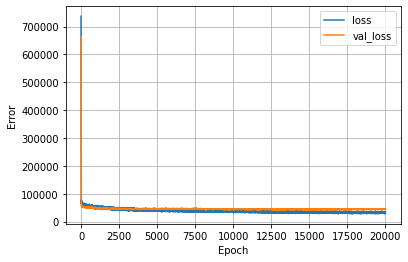

In [19]:
hf.plot_loss(history)

7/7 [==============================] - 0s 1ms/step


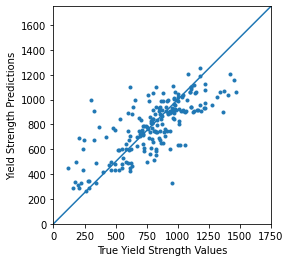

In [20]:
test_predictions = yield_model.predict(yield_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(yield_test_labels, test_predictions, marker=".")
plt.xlabel('True Yield Strength Values')
plt.ylabel('Yield Strength Predictions')
lims = [0, 1750]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig("pictures/yield_model.pdf")
